In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


# Model selection (NCV)

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Uncomment to run model selection
# modelSelection(X_train, y_train)

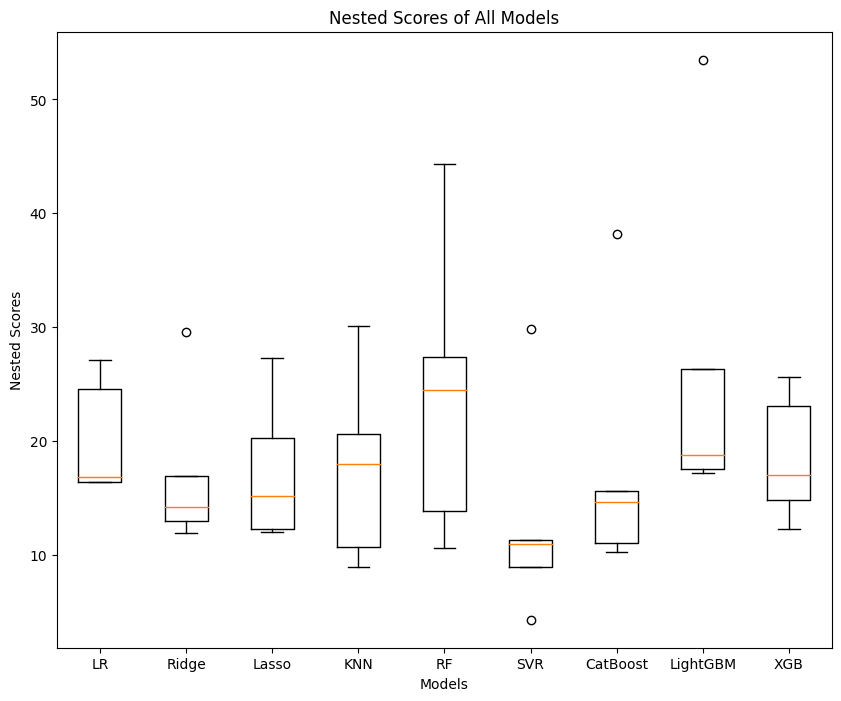

# ML training (Optuna)

In [3]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Define the hyperparameters to optimize
    C = trial.suggest_loguniform("C", 0.01, 100)
    epsilon = trial.suggest_loguniform("epsilon", 0.01, 1)
    gamma = trial.suggest_loguniform("gamma", 0.001, 1)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    degree = trial.suggest_int("degree", 2, 5)

    # Create the SVR model with the hyperparameters
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=degree)
    scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
    )
    return -scores.mean()


# Create the study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
final_model = SVR(**best_params)
final_model.fit(X_train, y_train)

[I 2024-02-15 18:50:53,248] A new study created in memory with name: no-name-c1b82b9c-bcda-4c8a-8d76-fb755acba479
[I 2024-02-15 18:50:53,269] Trial 0 finished with value: 19.94206280864943 and parameters: {'C': 14.338897362911986, 'epsilon': 0.8252459888833058, 'gamma': 0.03130547554430911, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: 19.94206280864943.
[I 2024-02-15 18:50:53,298] Trial 1 finished with value: 14.049621144302725 and parameters: {'C': 0.7457312288194103, 'epsilon': 0.019721555204552554, 'gamma': 0.028503251008572116, 'kernel': 'linear', 'degree': 5}. Best is trial 1 with value: 14.049621144302725.
[I 2024-02-15 18:50:53,322] Trial 2 finished with value: 22.175551865016907 and parameters: {'C': 6.117307387729811, 'epsilon': 0.03828175368754318, 'gamma': 0.26476011184736564, 'kernel': 'sigmoid', 'degree': 5}. Best is trial 1 with value: 14.049621144302725.
[I 2024-02-15 18:50:53,346] Trial 3 finished with value: 20.596805667399526 and parameters: {'C': 8.923

SVR(C=4.483603555401585, degree=5, epsilon=0.13767635194676467,
    gamma=0.4476771765848167, kernel='linear')

# Model evaluation (Bootstrap)

In [4]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values


mae_values = bootstrap(X_train, y_train, SVR(**final_model.get_params()))
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 233.92it/s]

Bootstraped Mean(MAE) = 15.136707858680364


SVR(C=4.483603555401585, degree=5, epsilon=0.13767635194676467,
    gamma=0.4476771765848167, kernel='linear')

# Explainable AI 

  0%|          | 0/27 [00:00<?, ?it/s]

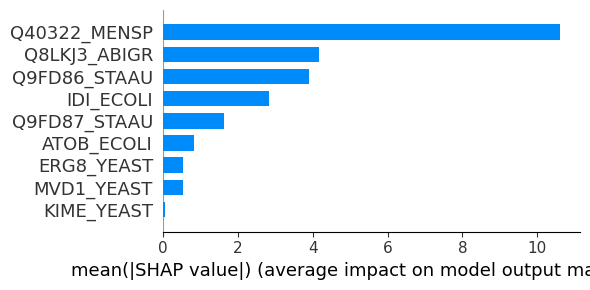

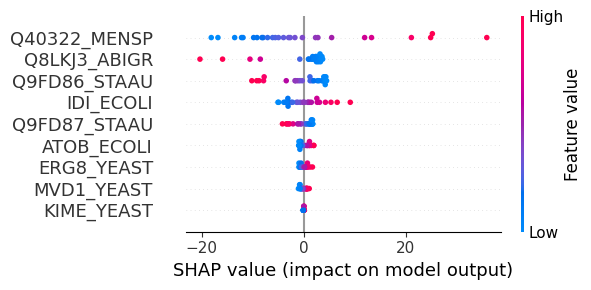

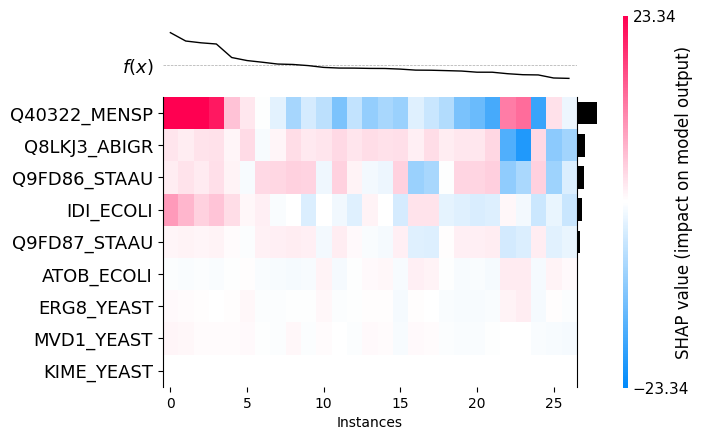

In [5]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(final_model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

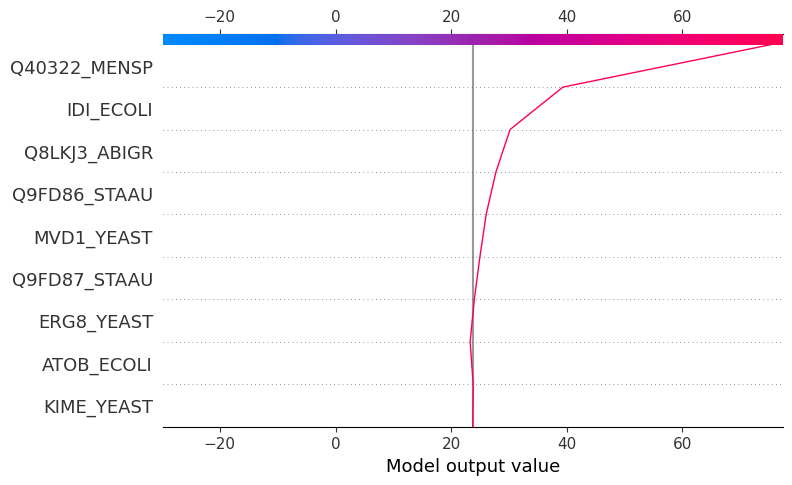

pred    75.293853
true    75.392610
Name: 0, dtype: float64


In [6]:
idx=0
shap.decision_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[idx].values, 
                   INPUT_VARS)

print(shap_df[['pred', 'true']].iloc[idx])

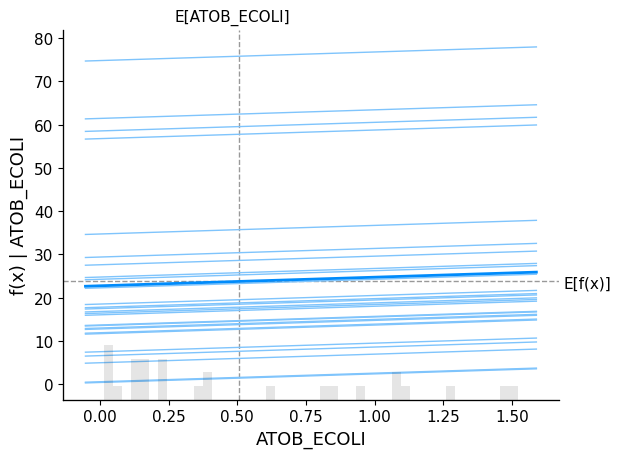

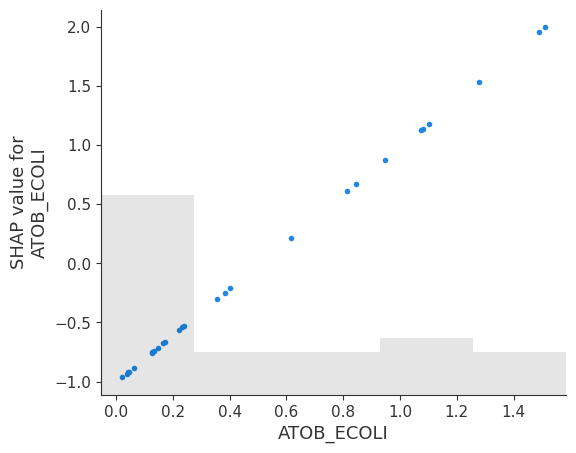

In [7]:
feature = "ATOB_ECOLI"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

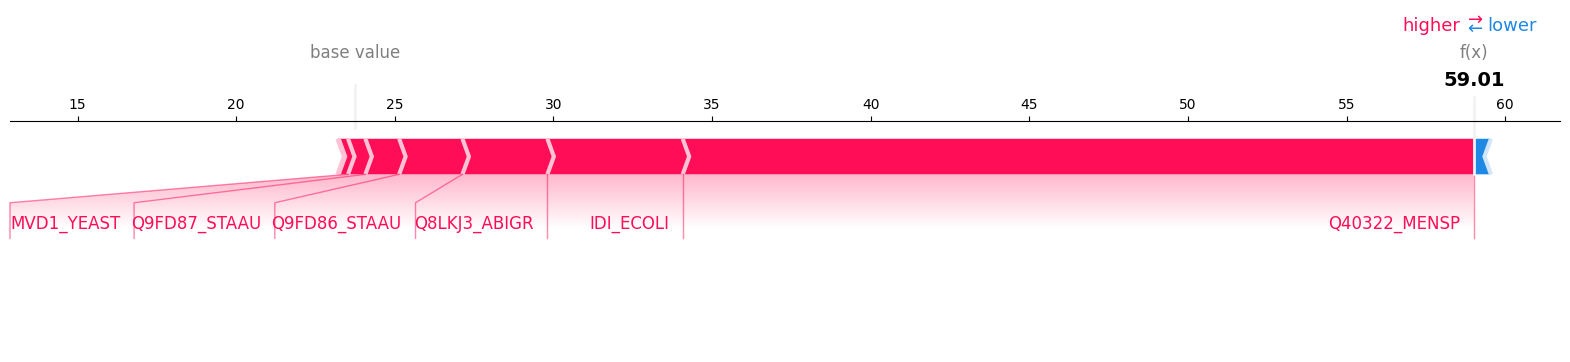

In [8]:
shap.force_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[2].values, 
                   features=INPUT_VARS,
                   matplotlib=True, show=True)

# Lime

In [9]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

Intercept 13.717413490580931
Prediction_local [74.87505548]
Right: 81.93196361143649


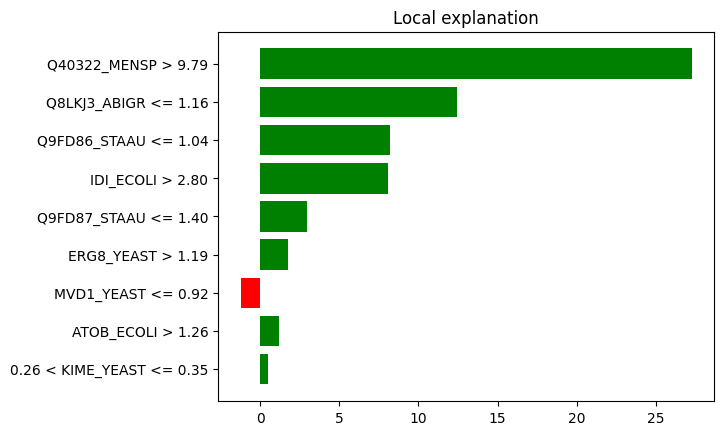

In [75]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_synth.values, feature_names=INPUT_VARS,  
                                                   verbose=True, mode='regression')
i = 0
exp = explainer.explain_instance(X_synth.values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

In [11]:
# original bounds
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


Create new `sampling bounds`, to generate/recommend new strain designs.

In [16]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 10
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = 1.30 # bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 1.40

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 1.20

sampling_bounds["Q9FD86_STAAU"].loc["min"] = bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 1.10

sampling_bounds["MVD1_YEAST"].loc["min"] = bounds["MVD1_YEAST"].loc["min"]
sampling_bounds["MVD1_YEAST"].loc["max"] = 1

sampling_bounds["ERG8_YEAST"].loc["min"] = 1.10
sampling_bounds["ERG8_YEAST"].loc["max"] = bounds["ERG8_YEAST"].loc["max"]

sampling_bounds["KIME_YEAST"].loc["min"] = 0.20
sampling_bounds["KIME_YEAST"].loc["max"] = 0.40 # bounds["KIME_YEAST"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.80
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
3490,1.569337,1.471844,3.419090,0.213952,0.664645,12.078994,0.080464,0.161371,0.682544,86.844056
4804,1.435817,1.203278,3.317115,0.333765,0.953050,12.096218,0.168313,0.032152,0.053517,86.651424
1049,1.323961,1.380175,3.375432,0.370482,0.962766,12.183105,0.103068,0.071109,1.203548,86.518667
364,1.340098,1.469374,3.407432,0.210751,0.848762,12.138721,0.217241,0.040426,0.786046,86.448772
7890,1.582132,1.498511,3.424203,0.346789,0.738711,12.148781,0.225789,0.132158,1.036549,86.412962
9847,1.646743,1.437667,3.368843,0.374014,0.422291,11.987223,0.081026,0.196412,0.320570,86.230894
4037,1.638803,1.326500,3.265902,0.242636,0.914332,12.132059,0.154211,0.279118,0.258108,86.044879
5688,1.369312,1.401971,3.274644,0.302828,0.956311,12.092765,0.196799,0.127987,0.177479,86.025591
4762,1.349689,1.342251,3.174704,0.330708,0.925210,12.173322,0.073491,0.028421,0.804661,85.995286
5905,1.448601,1.284069,3.408972,0.299567,0.793155,12.166786,0.418745,0.042858,0.262356,85.920188


# Counterfactuals (`DiCE`)

In [18]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=20,
    desired_range=[83, 90],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:14<00:00, 14.31s/it]

Query instance (original outcome : 27.91730308532715)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1654,0.4407,1.8527,0.2555,1.129,4.5317,0.8922,0.2786,0.3756,27.917303



Diverse Counterfactual set (new outcome: [83, 90])


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,1.3,1.1,2.8666,0.2644,0.9502,12.1575,0.0605,0.2603,0.0429,83.59392135551914
0,1.3337,1.1,3.3884,0.2459,0.9966,12.0669,0.2891,0.028,0.3296,85.51156231198269
0,1.3,1.1,2.8,0.2666,0.8816,12.0633,0.0605,0.028,0.0429,83.4822141816598
0,1.3,1.1,3.341,0.2474,0.9906,12.1164,0.0605,0.1305,0.0429,86.6224770144432
0,1.3,1.1,3.2398,0.243,0.7066,12.1484,0.3272,0.0333,0.6425,84.09073908355614
0,1.4625,1.1,3.1294,0.2616,0.7913,11.9737,0.386,0.0861,0.0429,83.13222864956376
0,1.5127,1.1487,3.3541,0.25,0.9779,11.8903,0.5312,0.1417,0.13,83.3046079767432
0,1.5177,1.1487,3.2989,0.25,0.9259,11.8903,0.5312,0.1417,0.0535,83.02436595419266
0,1.3,1.1,2.8,0.2474,0.4215,12.1612,0.1041,0.028,0.0429,83.21686228787405
0,1.3,1.1,2.8,0.2474,0.4215,12.1612,0.0669,0.028,0.0429,83.41752484079834


# PCA

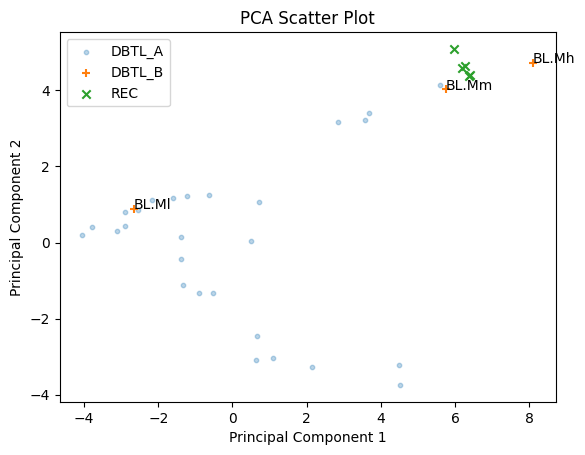

BL.Mh    127.99494
BL.Mm    119.81367
BL.Ml      6.72018
Name: Limonene, dtype: float64


In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:5])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [42]:
df_A.sort_values("Limonene", ascending=False, inplace=True)
df_A.head(3)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
B.Ml,0.1654,0.4407,1.8527,0.2555,1.1290,4.5317,0.8922,0.2786,0.3756,104.53655
2X.Mm,0.2231,0.7901,2.7354,0.3744,1.9592,9.2338,0.4335,0.5118,0.5409,101.20540
2X.Mh,0.2384,0.9413,3.1813,0.4010,2.1936,11.2037,0.2968,0.7816,0.7488,75.39261


In [66]:
final_model.predict(df_B[INPUT_VARS])

array([68.72045975, 83.97342937, 18.18359022])

In [74]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)

Euclidean distance: 9.165288149862807
Manhattan distance: 19.876282567967813
Cosine distance: 0.3002028758554479
Pearson correlation: 0.5397102095384656
